In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

## Train model

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate model performance
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Training accuracy: 0.9582
Test accuracy: 0.9387


## Calculate feature importance


Top 10 most important features:
                          Feature  Importance
5                 TFE Out flow SP    0.090117
14        FFTE Heat temperature 1    0.081754
10         FFTE Discharge density    0.075666
16        FFTE Heat temperature 3    0.063647
24  TFE Production solids density    0.054110
3       FFTE Production solids SP    0.052530
12         FFTE Feed flow rate PV    0.052014
15        FFTE Heat temperature 2    0.046890
4          FFTE Steam pressure SP    0.041613
6        TFE Production solids SP    0.040146
27                 TFE Tank level    0.039273
18         FFTE Steam pressure PV    0.036877
11          FFTE Discharge solids    0.032929
21              TFE Motor current    0.031547
17      FFTE Production solids PV    0.030981


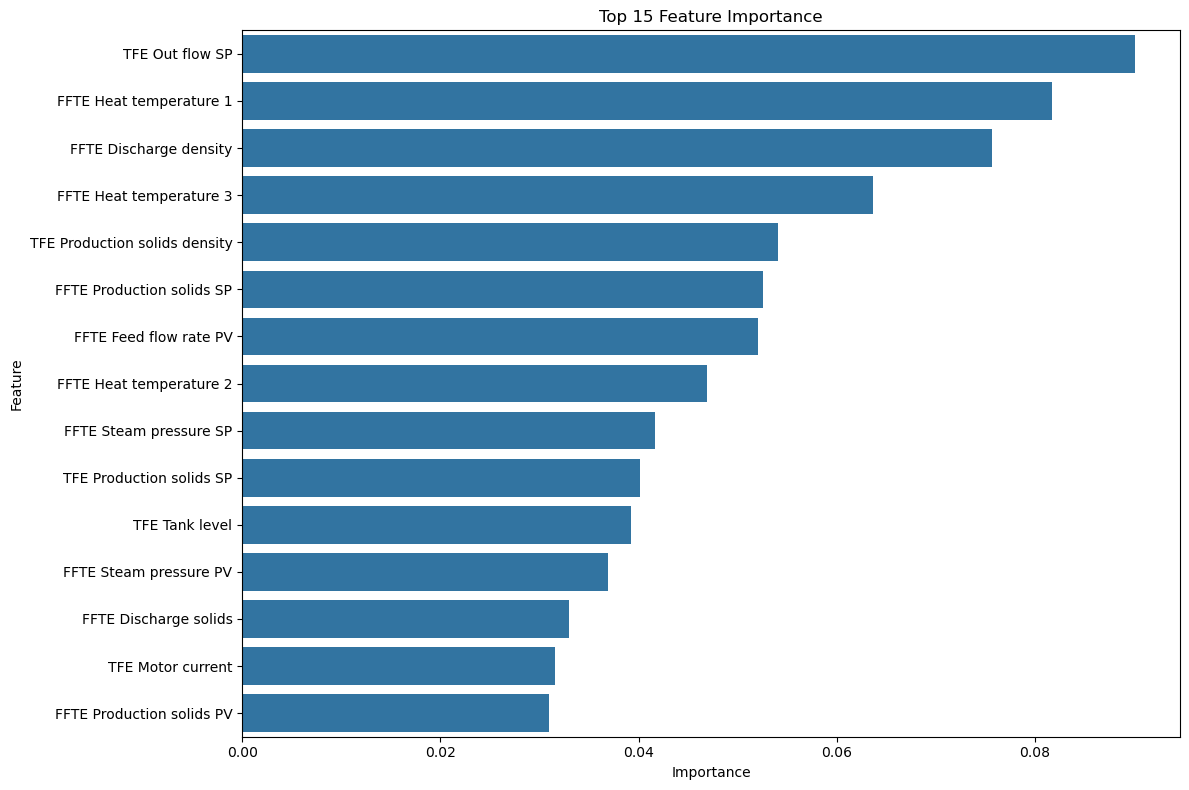

In [23]:
# Identify the most important features
feature_importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print top 10 most important features
print("\nTop 10 most important features:")
print(importance_df.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')

## Calculate permutation importance of each feature
#### - seperated into features and machine settings (SP) values

In [24]:
# Calculate permutation importance (more reliable than default feature importance)
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Permutation Importance': perm_importance.importances_mean}
)
perm_importance_df = perm_importance_df.sort_values('Permutation Importance', ascending=False)

print("\nTop 10 features by permutation importance:")
print(perm_importance_df.head(10))

# Focus optimization on the most important features
top_features = perm_importance_df.head(10)['Feature'].values
print(f"\nOptimising these top features: {top_features}")

# Extract control features (those with 'SP' in the name)
control_features = [col for col in X.columns if 'SP' in col]
print(f"\nControl features for optimisation: {control_features}")


Top 10 features by permutation importance:
                          Feature  Permutation Importance
5                 TFE Out flow SP                0.048215
10         FFTE Discharge density                0.046189
14        FFTE Heat temperature 1                0.044203
16        FFTE Heat temperature 3                0.022061
12         FFTE Feed flow rate PV                0.021900
3       FFTE Production solids SP                0.021337
24  TFE Production solids density                0.018438
0                            Part                0.014842
27                 TFE Tank level                0.014775
6        TFE Production solids SP                0.012252

Optimising these top features: ['TFE Out flow SP' 'FFTE Discharge density' 'FFTE Heat temperature 1'
 'FFTE Heat temperature 3' 'FFTE Feed flow rate PV'
 'FFTE Production solids SP' 'TFE Production solids density' 'Part'
 'TFE Tank level' 'TFE Production solids SP']

Control features for optimisation: ['FFTE Feed so

## Optimise with global differential_evolution function

In [31]:
# Objective function: maximize class 1 probability
def objective_function(x, model, feature_names):
    # Start with the average feature values
    input_values = X_train.mean().copy()

    # Update control features with values from optimizer
    input_values[control_features] = x

    # Predict probability using proper feature names
    input_df = pd.DataFrame([input_values], columns=feature_names)
    prob = model.predict_proba(input_df)[0][1]

    return -prob  # Minimize negative = maximize actual probability

# Set bounds based on training data
bounds = [(X_train[f].min(), X_train[f].max()) for f in control_features]

# Initial guess: use mean of class 1 samples, fallback to full mean
if (y_train == 1).sum() > 0:
    initial_guess = class_1_samples[control_features].mean().tolist()
else:
    initial_guess = X_train[control_features].mean().tolist()

# Run differential evolution
print("\n--- Running Global Optimization ---")
result = differential_evolution(
    func=objective_function,
    bounds=bounds,
    args=(model, X_train.columns),
    maxiter=100,
    popsize=20,
    seed=42
)

# Output results
max_prob = -result.fun
optimal_values = result.x
print(f"Optimization successful: {result.success}")
print(f"Max predicted probability of class 1: {max_prob:.4f}")

# Format output nicely
optimal_sp = pd.DataFrame({
    'Feature': control_features,
    'Original Mean': X_train[control_features].mean().values,
    'Optimized Value': optimal_values
})

print("\nOptimized Setpoint Values:")
print(optimal_sp)



--- Running Global Optimization ---
Optimization successful: True
Max predicted probability of class 1: 0.5144

Optimized Setpoint Values:
                     Feature  Original Mean  Optimized Value
0        FFTE Feed solids SP       2.728636         0.599213
1  FFTE Production solids SP       0.697117         0.386375
2     FFTE Steam pressure SP       0.125902         0.058113
3            TFE Out flow SP       0.580125         0.590179
4   TFE Production solids SP       0.647432         0.734337
5     TFE Vacuum pressure SP       0.421041         0.097028
6      TFE Steam pressure SP       0.876002         0.873765


## Optimise with local minimize function

In [34]:
# --- Step 1: Build input with globally optimized values ---
optimal_input = X_train.mean().copy()
optimal_input[control_features] = optimal_values
optimal_input_df = pd.DataFrame([optimal_input], columns=X_train.columns)
final_prob = model.predict_proba(optimal_input_df)[0][1]
print(f"\nVerified probability (global): {final_prob:.4f}")

# --- Step 2: Refine with Local Optimization ---
print("\n--- Refining with Local Optimization ---")
result_local = minimize(
    objective_function,
    x0=optimal_values,
    args=(model, X_train.columns),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract refined results
local_optimal_values = result_local.x
local_max_prob = -result_local.fun
print(f"Local optimization successful: {result_local.success}")
print(f"Refined probability: {local_max_prob:.4f}")

# --- Step 3: Compare Global and Local Results ---
comparison_df = pd.DataFrame({
    'Feature': control_features,
    'Original Mean': X_train[control_features].mean().values,
    'Global Optimization': optimal_values,
    'Local Refinement': local_optimal_values
})
print("\nComparison of Optimization Results:")
print(comparison_df)

# --- Step 4: Verify Local Optimal Input ---
refined_input = X_train.mean().copy()
refined_input[control_features] = local_optimal_values
refined_input_df = pd.DataFrame([refined_input], columns=X_train.columns)
final_refined_prob = model.predict_proba(refined_input_df)[0][1]
print(f"\nVerified refined probability: {final_refined_prob:.4f}%")

# --- Step 5: Save Results ---
comparison_df.to_csv('data/optimized_setpoints.csv', index=False)



Verified probability (global): 0.5144

--- Refining with Local Optimization ---
Local optimization successful: True
Refined probability: 0.5144

Comparison of Optimization Results:
                     Feature  Original Mean  Global Optimization  \
0        FFTE Feed solids SP       2.728636             0.599213   
1  FFTE Production solids SP       0.697117             0.386375   
2     FFTE Steam pressure SP       0.125902             0.058113   
3            TFE Out flow SP       0.580125             0.590179   
4   TFE Production solids SP       0.647432             0.734337   
5     TFE Vacuum pressure SP       0.421041             0.097028   
6      TFE Steam pressure SP       0.876002             0.873765   

   Local Refinement  
0          0.599213  
1          0.386375  
2          0.058113  
3          0.590179  
4          0.734337  
5          0.097028  
6          0.873765  

Verified refined probability: 0.5144%
